In [1]:
import tensorflow as tf

import gempy as gp


from ipywidgets import interact, interactive
import os
import numpy as np
import sys
import timeit
import csv

import matplotlib.pyplot as plt


import tensorflow_probability as tfp
import pandas as pd
from gempy import create_data, map_series_to_surfaces
from gempy.assets.geophysics import GravityPreprocessing
tfd = tfp.distributions
sys.path.append('/Users/zhouji/Google Drive/RWTH/')
from regularModel import *
%matplotlib inline
modelName = 'model3b'

Active grids: ['regular']
tf.float64


(<Figure size 504x504 with 1 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x7fde8beb6790>)

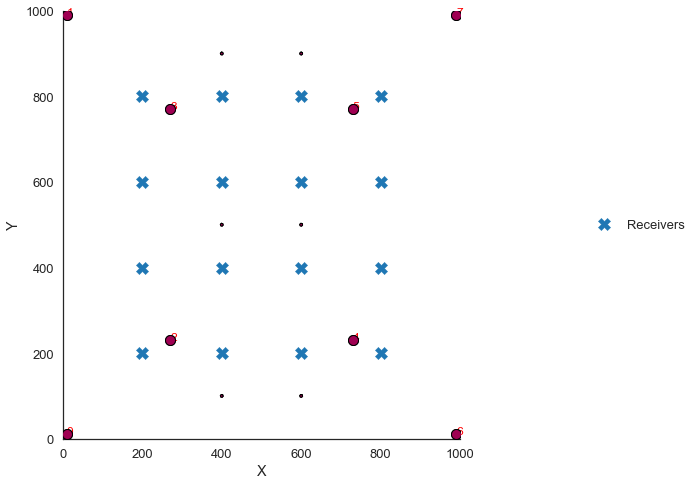

In [2]:
path = '/Users/zhouji/Google Drive/RWTH/GP_old/notebooks'
orientation_path = "/data/input_data/George_models/model2_1_orientations.csv"
surface_path = '/data/input_data/George_models/'+'model3'+'_surface_points.csv'

X = [200,400,600,800]
Y = [200,400,600,800]


r = []
for x in X:
    for y in Y:
        r.append(np.array([x,y]))
receivers = np.array(r)
receivers

model1 = Model(path,surface_path,orientation_path,receivers = receivers,dtype='float64')
model1.plot_model()

In [4]:

model1.sigma = 50
model1.cov_prior = ((model1.sigma))**2 * tf.eye(model1.Number_para, dtype=model1.tfdtype) 
model1.cov_prior_r = ((model1.sigma)/model1.rf)**2 * tf.eye(model1.Number_para, dtype=model1.tfdtype) #$$# double check here

In [6]:
model1.mu_prior = 780*(tf.ones(model1.mu_prior.shape, dtype = model1.tfdtype))
model1.mu_prior_r = (model1.mu_prior-model1.centers[2])/model1.rf+0.5001

In [7]:
mu = model1.mu_prior
cov_prior = model1.cov_prior
prior_list = []
for i in range(1000):
    mvn_prior = tfd.MultivariateNormalTriL(
              loc=mu,
              scale_tril = tf.linalg.cholesky(cov_prior))
    mvn_prior_ = tfd.Sample(mvn_prior,sample_shape=([1]))
    sample = mvn_prior_.sample()
    prior_list.append(tf.squeeze(sample))

In [8]:
model1.scalar_field(mu)
lith = model1.solutions.lith_block
lith

array([3., 3., 3., ..., 1., 1., 1.])

In [9]:
# load results
with open('/Users/zhouji/Google Drive/RWTH/Data/gpCN_model3b.json') as f:
  data = json.load(f)
data = json.loads(data)
samples_gpCN = np.asarray(data['samples_gpCN'])

In [10]:
def lith_list_all(mu_list):
    lith_list = []
    for mu in mu_list:
  
        model1.scalar_field(mu)
        lith = model1.solutions.lith_block
        lith_list.append(lith)

    lith_list = np.array(lith_list)
    
    # only plot the upper layer, so keep 
    lith_list[lith_list==3] = 2
    return lith_list

def entropy(prob_list):
    H = 0
    for prob_i in prob_list:
        if prob_i != 0:
            H -= prob_i*math.log(prob_i,3)
    return H 

def full_entropy(mu_list):
    
    H_t = []
    lith_list = lith_list_all(mu_list)
    for i in range(lith_list.shape[1]):
        prob_list = Probability(lith_list,position= i)
        H_t.append(entropy(prob_list))
    return H_t

import math
## calculate probability of each colum
def Probability(lith_list,position):
    num_1 = np.count_nonzero(lith_list[:,position]==1)
    num_2 = np.count_nonzero(lith_list[:,position]==2)
    num_3 = np.count_nonzero(lith_list[:,position]==3)
    total = np.sum((num_1,num_2,num_3))
    prob_1 = num_1/total
    prob_2 = num_2/total
    prob_3 = num_3/total
    return np.array([prob_1,prob_2,prob_3])

In [11]:
H = np.array(full_entropy(prior_list))

In [12]:
H_posterior = np.array(full_entropy(samples_gpCN[:1000,]))

In [13]:
H.shape

(1000000,)

In [14]:
H_mesh = np.reshape(H,[100,100,100])

In [15]:
import pyvista as pv

In [16]:
p = pv.Plotter(notebook =False)# Create Structured Grid for PyVista
# create 100 * 100 * 100 structured grid
x = np.arange(0, H_mesh.shape[1]*10, 10)
y = np.arange(0, H_mesh.shape[0]*10, 10)
z = np.arange(0, H_mesh.shape[2]*10, 10)

x, y, z = np.meshgrid(x, y, z)
grid_prior = pv.StructuredGrid(z, x, y)
grid_post = pv.StructuredGrid(z, x, y)
#Assign entropy value to grid
grid_prior["Prior Entropy"] = H
grid_post["Posterior Entropy"] = H_posterior

sargs = dict(
    n_labels=10,
    fmt="%.2f",
    color='black'
    )


In [17]:
slices_prior = grid_prior.slice_along_axis(n=3, axis="y")
slices_post = grid_post.slice_along_axis(n=3, axis="y")

In [18]:
pv.set_plot_theme("document")

p = pv.Plotter(notebook =False,shape=(1,2))
p.add_text('Prior')
p.add_mesh(slices_prior,opacity = 0.75)
p.show_bounds(location='back',bounds = model1.extent)

p.subplot(0,1)
p.add_text('Posterior')
p.add_mesh(slices_post,opacity = 0.75)
p.show()

[(3292.0202496898387, 3291.5202496898387, 3292.0202496898387),
 (495.0, 494.5, 495.0),
 (0.0, 0.0, 1.0)]

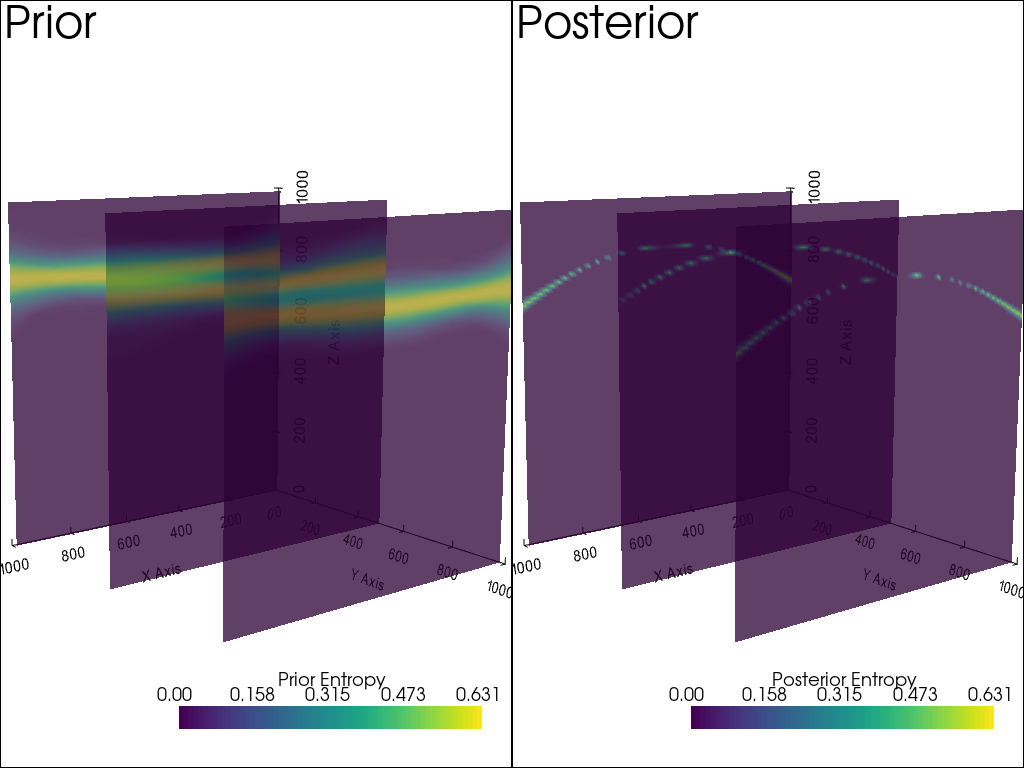

In [19]:
pv.set_plot_theme("document")

p = pv.Plotter(notebook =True,shape=(1,2))
p.add_text('Prior')
p.add_mesh(slices_prior,opacity = 0.75)
p.show_bounds(location='back',bounds = model1.extent)

camera_position = [(2992.1310542910605, 3529.543820105359, 1258.641703051394),
 (495.0, 494.5, 495.0),
 (-0.11532475572704834, -0.1520968585648239, 0.9816143572356757)]

p.camera_position = camera_position
p.subplot(0,1)
p.add_text('Posterior')
p.add_mesh(slices_post,opacity = 0.75)
p.show_bounds(location='back',bounds = model1.extent)
p.camera_position = camera_position
p.show(screenshot='/Users/zhouji/Documents/Geophysics/Liang/Fig/entropy3b.png')



In [35]:
p = pv.Plotter(notebook =False)# Create Structured Grid for PyVista
x = np.arange(0, H_mesh.shape[1]*10, 10)
y = np.arange(0, H_mesh.shape[0]*10, 10)
z = np.arange(0, H_mesh.shape[2]*10, 10)

x, y, z = np.meshgrid(x, y, z)
grid_prior = pv.StructuredGrid(z, x, y)
grid_post = pv.StructuredGrid(z, x, y)
#Assign entropy value to grid
grid_prior["Prior Entropy"] = H
grid_post["Posterior Entropy"] = H_posterior

sargs = dict(
    n_labels=10,
    fmt="%.2f",
    color='black'
    )
